<a href="https://colab.research.google.com/github/MagdaPla/UNET_PPM/blob/master/unet_ppm_mpla_copiaG_uoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
system("sudo apt-get update")
system("sudo apt-get install -y libmagick++-dev")

install.packages("magick")
install.packages("keras")
install.packages("tfdatasets")
install.packages("tidyverse")
install.packages("rsample")
install.packages("reticulate")
install.packages("tibble")
install.packages("here")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘unet’ is not available (for R version 3.6.3)”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘forge’, ‘tfestimators’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘future’, ‘globals’, ‘furrr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(keras)
library(tfdatasets)
library(tidyverse)
library(rsample)
library(reticulate)
library(tibble)
library(here)
library(magick)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /content

Linking to ImageMagick 6.9.7.4
Enabled features: fontconfig, freetype, fftw, lcms, pango, x11
Disabled features: cairo, ghostscript, rsvg, webp



In [0]:
# for reproducibility
tf<-tf$compat.v1
tf$set_random_seed(100)

In [0]:
#Now let's start building building our model. We will use `tfdatasets` to build our
#data loading and pre-processing pipeline. 
data <- tibble(
  img = list.files(here::here("sample_data/rgb"), full.names = TRUE),
  mask = list.files(here::here("sample_data/masc"), full.names = TRUE)
)

data <- initial_split(data, prop = 0.8)

In [0]:
#Ok, now let's define a pipeline to read the files and decode them as images. In
# this case the images are `.jpeg` files and the masks are `.gif` files.
training_dataset <- training(data) %>%  
  tensor_slices_dataset()%>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
    mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
  ))

In [0]:
#you can easily see the output of this chunk with:
example <- training_dataset %>% as_iterator() %>% iter_next()

In [0]:
#The above loaded the images into into a `uint8` Tensor. Which is great for reading 
#as it uses less memory. However for modelling we prefer having `float32` Tensors, 
#and that the values are in the [0,1] range. That's what we will fix now:
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
    mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
  ))

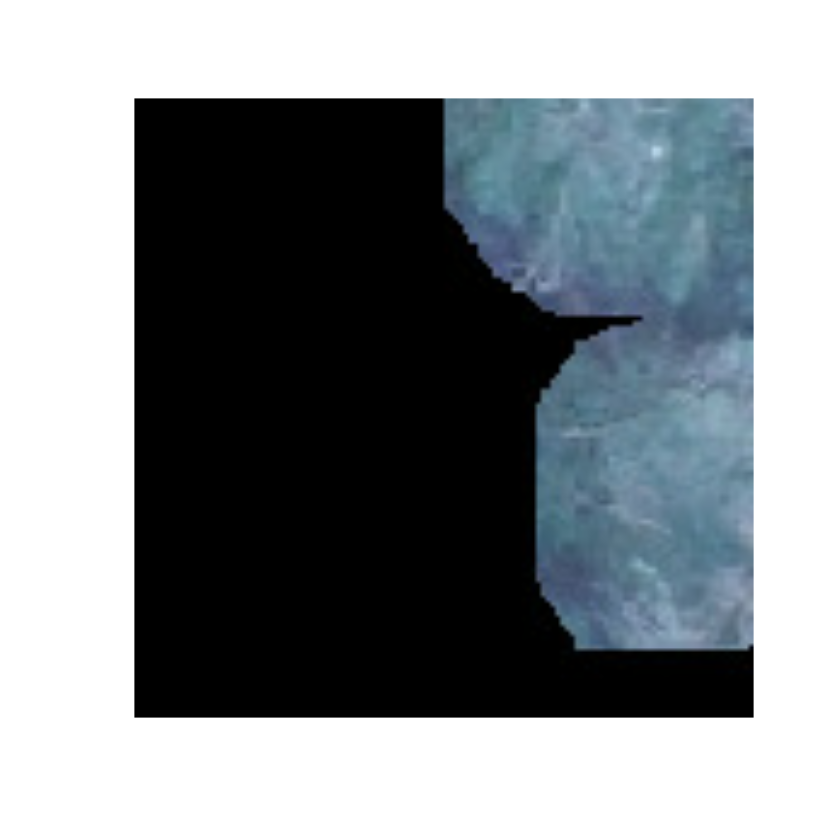

In [7]:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
# ome kind of data augmentation strategy
random_bsh <- function(img) {
  img %>% 
    tf$image$random_brightness(max_delta = 0.3) %>% 
    tf$image$random_contrast(lower = 0.5, upper = 0.7) %>% 
    tf$image$random_saturation(lower = 0.5, upper = 0.7) %>% 
    tf$clip_by_value(0, 1) # clip the values into [0,1] range.
}

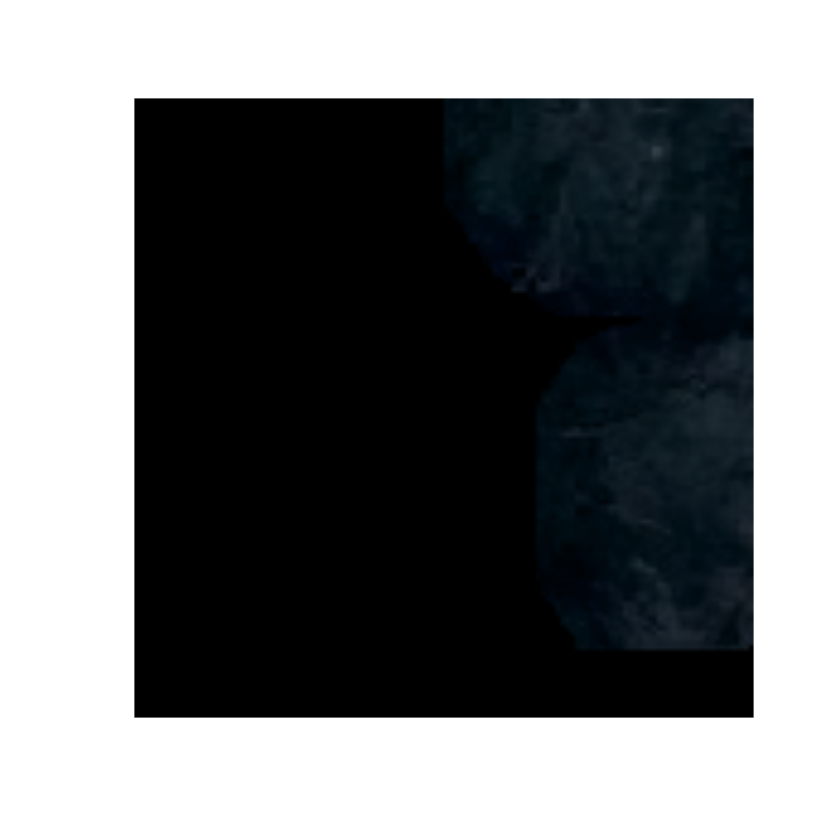

In [9]:
# map this function over the images 
training_dataset <- training_dataset %>% 
  dataset_map(~.x %>% list_modify(
    img = random_bsh(.x$img)
  ))
# and plot:
example <- training_dataset %>% as_iterator() %>% iter_next()
example$img %>% as.array() %>% as.raster() %>% plot()

In [0]:
#we could create a function with the above code and reuse it to create
#the validation dataset, and that's what we are going to do.

create_dataset <- function(data, train, batch_size = 32L) {
  
  dataset <- data %>% 
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$decode_jpeg(tf$io$read_file(.x$img)),
      mask = tf$image$decode_gif(tf$io$read_file(.x$mask))[1,,,][,,1,drop=FALSE]
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
      mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
    ))
  
  if (train) {
    dataset <- dataset %>% 
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      )) 
  }
  
  if (train) {
    dataset <- dataset %>% 
      dataset_shuffle(buffer_size = batch_size*128)
  }
  
  dataset <- dataset %>% 
    dataset_batch(batch_size)
  
  
  
  dataset %>% 
    dataset_map(unname) # Keras needs an unnamed output.
}

In [0]:
# Now we can create our training and validation datasets:
training_dataset <- create_dataset(training(data), train = TRUE)
validation_dataset <- create_dataset(testing(data), train = FALSE)

In [0]:
# above, we have prepared our data pipeline. Now we need to build the model, 
# using the model of forest segmentation paper (Wagner et al)

# Primer calculem la mètrica i "loss" de manera personalitzada: 
# mirar però si em convé més utilitzar "binari crosentropy" o aquest... valoro

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

# per calcular el paràmetre "loss" segons Wagner et al,
# valoro si cal posar-la o no, de moment he utilitzat la BinaryCrossentropy
# bce_dice_loss <- function(y_true, y_pred) {
#  result <- loss_binary_crossentropy(y_true, y_pred) +
#    (1 - dice_coef(y_true, y_pred))
#  return(result)
#}

In [24]:
# the model, and the compilation of the model:
model <- keras_model_sequential()

get_unet_128 <- function(input_shape = c(128, 128, 3),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            activation = "sigmoid")
  
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.0001),
    loss = "BinaryCrossentropy",
    metrics = c(dice_coef)
  )
  
  return(model)
}

model <- get_unet_128()
summary(model)

Model: "model_2"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      [(None, 128, 128, 0                                   
________________________________________________________________________________
conv2d_46 (Conv2D)        (None, 128, 128,  1792     input_3[0][0]              
________________________________________________________________________________
batch_normalization_44 (B (None, 128, 128,  256      conv2d_46[0][0]            
________________________________________________________________________________
activation_44 (Activation (None, 128, 128,  0        batch_normalization_44[0][0
________________________________________________________________________________
conv2d_47 (Conv2D)        (None, 128, 128,  36928    activation_44[0][0]        
________________________________________________________________________________
batch_norma

In [0]:
checkpoint_path <- "weights_r/cp.ckpt"

# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = checkpoint_path,
  save_weights_only = TRUE,
  save_best_only = TRUE,
  verbose = 1
)

history <- model %>% fit(
  training_dataset,
  epochs = 100,
  validation_data = validation_dataset, 
  callbacks = list(cp_callback), # pass callback to training,
  verbose= 2
)



`geom_smooth()` using formula 'y ~ x'



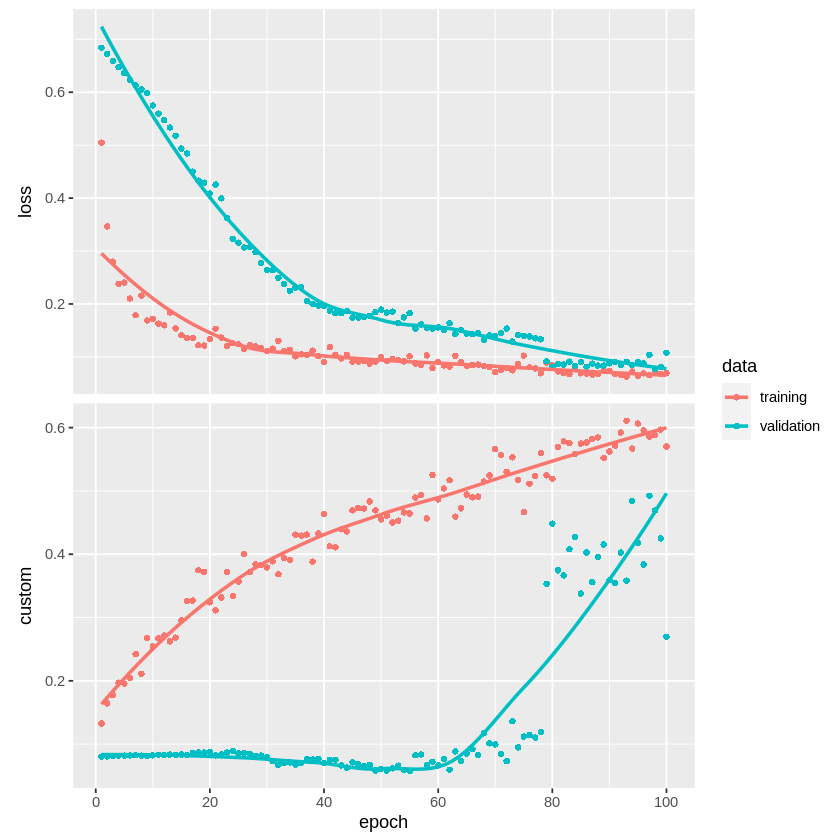

In [26]:
plot(history)

In [27]:
print(history)


Final epoch (plot to see history):
      loss: 0.06968
    custom: 0.5702
  val_loss: 0.1078
val_custom: 0.2695 


In [28]:
# evaluate accuracy on the validation dataset
model %>% evaluate(validation_dataset,verbose = 0)

loss    custom 
0.1077665 0.2695248

In [0]:
# estic buscant altres maneres de fer-ho, a continuació
# make predictions about some images
batch <- validation_dataset %>% as_iterator() %>% iter_next()
predictions <- predict(model, batch)

In [0]:
kk<-model%>%predict(validation_dataset)

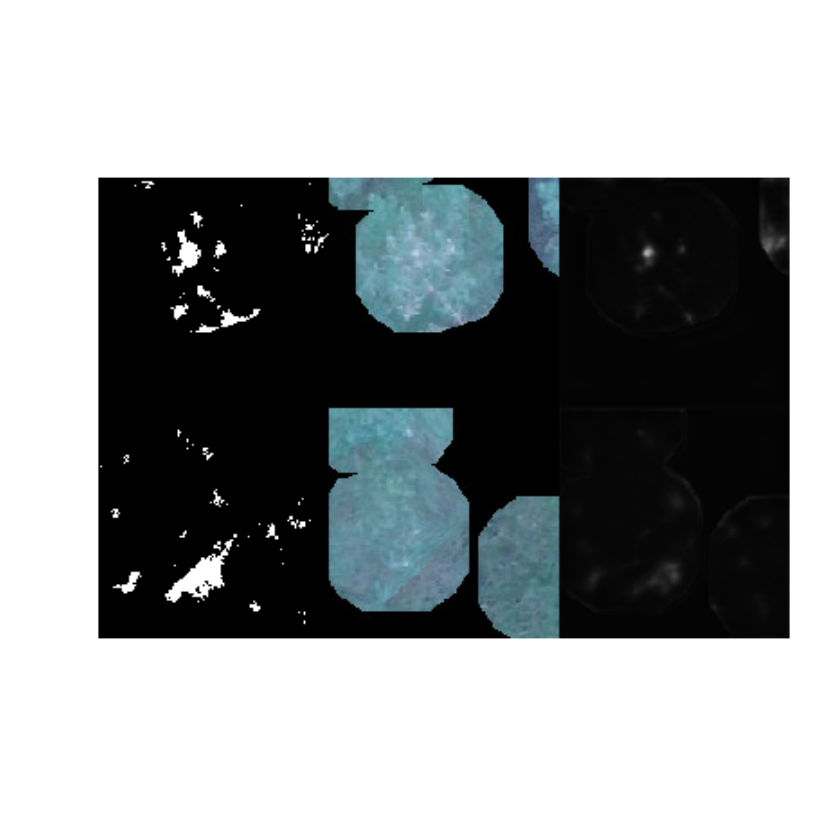

In [32]:
# to view the images, original masks and predicted mask:

images <- tibble(
  image = batch[[1]] %>% array_branch(1),
  predicted_mask = predictions[,,,1] %>% array_branch(1),
  mask = batch[[2]][,,,1]  %>% array_branch(1)
) %>% 
  sample_n(2) %>% 
  map_depth(2, function(x) {
    as.raster(x) %>% magick::image_read()
  }) %>% 
  map(~do.call(c, .x))


out <- magick::image_append(c(
  magick::image_append(images$mask, stack = TRUE),
  magick::image_append(images$image, stack = TRUE), 
  magick::image_append(images$predicted_mask, stack = TRUE)
  )
)

plot(out)